In [ ]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from scipy.stats import norm
from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU
from keras import backend
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rf=pd.read_csv('/content/drive/MyDrive/black_scholes_option_pricing/risk_free_rate/India 10-Year Bond Yield Historical Data.csv')
rf.drop(['Open','High','Low' ,'Change %'],axis=1,inplace=True)
rf['Date']=pd.to_datetime(rf['Date'])
rf=rf.set_index(['Date'])

In [ ]:
spot=pd.read_csv('/content/garch_vix.csv')
#spot['return']=spot['Adj Close'].pct_change(1)
#spot['volatility']=spot['return'].rolling(20).std()
spot['Garch_Volatility']=spot['Garch_Volatility']*np.sqrt(252)
#spot.drop(['Open','High','Low' ,'Close','Volume'],axis=1,inplace=True)
spot=spot.set_index(['Date'])

In [ ]:
spotdf=spot.join(rf,how='inner')
spotdf

,Strike Price,Close,Expiration,Adj Close,return,volatility,Price_x,bs_call,Garch_Volatility,Price_y,Price
Date,,,,,,,,,,,
2013-12-31,6200,199.65,30,6304.000000,0.002051,0.135503,8.820,188.621115,0.161481,15.08,8.820
2013-12-31,6300,131.00,30,6304.000000,0.002051,0.135503,8.820,124.059028,0.161481,15.08,8.820
2013-12-31,6400,79.00,30,6304.000000,0.002051,0.135503,8.820,75.195204,0.161481,15.08,8.820
2013-12-31,6500,41.35,30,6304.000000,0.002051,0.135503,8.820,41.683668,0.161481,15.08,8.820
2013-12-31,6600,18.60,30,6304.000000,0.002051,0.135503,8.820,21.015752,0.161481,15.08,8.820
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30,14050,18.40,1,13981.950195,0.003542,0.145312,5.899,17.485487,0.161295,20.79,5.899
2020-12-30,14100,8.15,1,13981.950195,0.003542,0.145312,5.899,7.560272,0.161295,20.79,5.899
2020-12-30,14150,3.30,1,13981.950195,0.003542,0.145312,5.899,2.797619,0.161295,20.79,5.899


In [ ]:
path='/content/drive/MyDrive/black_scholes_option_pricing/call_csv/'
z=os.listdir(path)
ce=[]
for i in z:
    call=pd.read_csv(path+i)
    ce.append(call)

In [ ]:
for i in ce:
  i.columns=['Date','Strike Price','Close','Expiration'] 

In [ ]:
ce[5].columns=['Strike Price','Date','Close','Expiration'] 

In [ ]:
call=pd.concat(ce)

In [ ]:
call=call.set_index(['Date'])

In [ ]:
final_call=call.join(spotdf,how='inner')

In [ ]:
final_call.tail()

,Strike Price,Close,Expiration,Adj Close,return,volatility,Price
Date,,,,,,,
2020-12-30,14800,0.60,1,13981.950195,0.003542,0.145312,5.899
2020-12-30,14850,0.35,1,13981.950195,0.003542,0.145312,5.899
2020-12-30,14900,0.55,1,13981.950195,0.003542,0.145312,5.899
2020-12-30,14950,0.70,1,13981.950195,0.003542,0.145312,5.899
2020-12-30,15000,0.55,1,13981.950195,0.003542,0.145312,5.899


In [ ]:
path='/content/drive/MyDrive/black_scholes_option_pricing/put_csv/'
z=os.listdir(path)
pe=[]
for i in z:
    put=pd.read_csv(path+i)
    pe.append(put)

In [ ]:
for i in pe:
  i.columns=['Date','Strike Price','Close','Expiration'] 

In [ ]:
pe[5].columns=['Strike Price','Date','Close','Expiration'] 

In [ ]:
put=pd.concat(pe)

In [ ]:
put=put.set_index(['Date'])
final_put=put.join(spotdf,how='inner')

In [ ]:
final_put.dropna(inplace=True)

In [ ]:
final_call.dropna(inplace=True)

In [ ]:
final_call=spot

In [ ]:
final_call= final_call[final_call["Strike Price"].str.startswith('25JUN',na=False)== False]
final_call= final_call[final_call["Strike Price"].str.startswith('25Jun',na=False)== False]
final_put= final_put[final_put["Strike Price"].str.startswith('25JUN',na=False)== False]
final_put= final_put[final_put["Strike Price"].str.startswith('25Jun',na=False)== False]
final_put= final_put[final_put["Strike Price"].str.startswith('TY',na=False)== False]

In [ ]:
final_call['Strike Price']=final_call['Strike Price'].astype(int)
final_put['Strike Price']=final_put['Strike Price'].astype(int)

In [ ]:
def call_pricing(df):
  S=df['Adj Close']
  K= df["Strike Price"]
  t=df.Expiration/365
  r=df["Price_x"]/100
  sigma=df["Garch_Volatility"]
  d1=(np.log(S/K)+(r+(sigma**2)/2)*t)/(sigma*(t**0.5))
  d2=d1-sigma*(t**0.5)
  Blackscholes_pred=  S*norm.cdf(d1)-K*np.exp(-r * t)*norm.cdf(d2)
  return Blackscholes_pred

In [ ]:
final_call.columns

Index(['Strike Price', 'Close', 'Expiration', 'Adj Close', 'return',
       'volatility', 'Price_x', 'bs_call', 'Garch_Volatility', 'Price_y'],
      dtype='object')

In [ ]:
x=call_pricing(final_call)

In [ ]:
final_call['bs_call']=x

In [ ]:
def put_pricing(df):
  S=df['adj_close']
  K= df["Strike Price"]
  t=df.Expiration/365
  r=df["Price"]/100
  sigma=df["volatility"]
  d1=(np.log(S/K)+(r+(sigma**2)/2)*t)/(sigma*(t**0.5))
  d2=d1-sigma*(t**0.5)
  Blackscholes_pred= K*np.exp(-r * t)*norm.cdf(-d2) - S*norm.cdf(-d1)
  return Blackscholes_pred

In [ ]:
final_put.columns

Index(['Strike Price', 'close', 'Expiration', 'adj_close', 'return',
       'volatility', 'Price'],
      dtype='object')

In [ ]:
y=put_pricing(final_put)

In [ ]:
final_put['bs_put']=y

In [ ]:
final_call.to_csv('call_black_scholes.csv')
#final_put.to_csv('put_black_scholes.csv')

In [ ]:
callx_train,cally_train,callx_test,cally_test=train_test_split(final_call.drop['close'],final_call[''])

In [ ]:
final_call


,Strike Price,Close,Expiration,Adj Close,return,volatility,Price_x,bs_call,Garch_Volatility,Price_y
Date,,,,,,,,,,
2013-12-31,6200,199.65,30,6304.000000,0.002051,0.135503,8.820,204.412637,0.161481,15.08
2013-12-31,6300,131.00,30,6304.000000,0.002051,0.135503,8.820,142.391311,0.161481,15.08
2013-12-31,6400,79.00,30,6304.000000,0.002051,0.135503,8.820,93.674003,0.161481,15.08
2013-12-31,6500,41.35,30,6304.000000,0.002051,0.135503,8.820,57.962504,0.161481,15.08
2013-12-31,6600,18.60,30,6304.000000,0.002051,0.135503,8.820,33.633170,0.161481,15.08
...,...,...,...,...,...,...,...,...,...,...
2020-12-30,14050,18.40,1,13981.950195,0.003542,0.145312,5.899,21.425664,0.161295,20.79
2020-12-30,14100,8.15,1,13981.950195,0.003542,0.145312,5.899,10.321128,0.161295,20.79
2020-12-30,14150,3.30,1,13981.950195,0.003542,0.145312,5.899,4.392487,0.161295,20.79


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
x=np.array(final_call['bs_call']).reshape(-1,1)
y=np.array(final_call['Close']).reshape(-1,1)
reg=LinearRegression().fit(x,y)
mae= mean_absolute_error(x,y)

In [ ]:
print(reg.score(x,y),mae)

0.9454474281762437 43.1815003745753


In [ ]:
from sklearn.metrics import r2_score
r2_score(final_call['Close'],final_call['bs_call'])

0.943948611341103

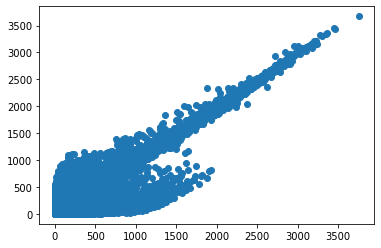

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x,y)